# Rutile TiO$_2$ polaron hopping
## Overview
In this notebook, we will:
- Sample the potential energy surface of the polaron hop of TiO$_2$
- Fit it to harmonic wells with both a hard cut off to exclude anharmonic points, or Boltzmann weighting of the fit
- Calculate and compare the polaron hopping rate from Marcus theory

In [1]:
using CarrierCapture
using Plots, LaTeXStrings
using DataFrames
@show VERSION

┌ Info: Precompiling CarrierCapture [05287f9a-33ab-11e9-31fb-01c88c8bf238]
└ @ Base loading.jl:1260


VERSION = v"1.4.1"


v"1.4.1"

## Adiabatic PES
Here, we read the energies of linearly interpolation geometries from a set of DFT calculations. We then normalise it, such that its minimum sits at 0.

In [2]:
pot = pot_from_file("data/tio2_interpolation.dat")

pot.QE_data.E = pot.QE_data.E .- minimum(pot.QE_data.E)

pot.Q0 = 0
pot.E0 = 0

0

Now, we fit the surface to a spline, by default of order 2.

In [3]:
pot.func_type = "spline"
fit_pot!(pot)

Potential fitting: 
=========spline==========



Spline1D(knots=[0.0,0.15 … 0.85,1.0] (10 elements), k=2, extrapolation="extrapolate", residual=0.0)

## Diabatic PESs
We now split the potential in half. In this case, the saddle point is included, therefore we discard the maximum, which does not belong to the initial or final sets of sample points.

In [4]:
pot_i, pot_f = cleave_pot(pot,discard_max=true)

# option to filter out points above kT
#filter_sample_points!(pot_i)
#filter_sample_points!(pot_f)

pot_i.T_weight = true
pot_f.T_weight = true

fit_pot!(pot_i)
fit_pot!(pot_f)

Potential fitting: 
========harmonic fit========

Weights: [1.0, 0.8360839403235178, 0.5197936274787739, 0.27581866165382024, 0.15479674789667247]===========Fit===========
Function: harmonic_fittable
Best fit: [0.33132582640829045]

Potential fitting: 
========harmonic fit========

Weights: [0.15479674789667247, 0.27581866165382024, 0.5197936274787739, 0.8360839403235178, 1.0]===========Fit===========
Function: harmonic_fittable
Best fit: [0.33132582640829406]



## Plot
Let's put it all together in one plot

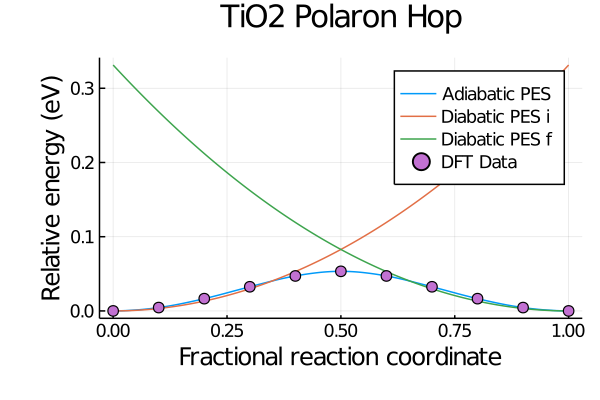

In [5]:
plt = plot(pot.Q,pot.E,lab = "Adiabatic PES",thickness_scaling = 1.5)
plt = plot!(pot_i.Q,pot_i.E,lab = "Diabatic PES i")
plt = plot!(pot_f.Q,pot_f.E,lab = "Diabatic PES f")
scatter!(pot.QE_data.Q,pot.QE_data.E, lab="DFT Data",
    xlabel = "Fractional reaction coordinate",
    ylabel = "Relative energy (eV)",
    legend = true,
    title = "TiO2 Polaron Hop")


## Get transport properties

In [6]:
tc = TransferCoord(pot_i, pot_f, pot)
coupling = get_coupling(tc)
reorg_ener = get_reorg_energy(tc)
activation_ener = get_activation_energy(tc)
transfer_rate = get_transfer_rate(tc)
dist = 2.904e-8
temp = 293.15
mobility = einstein_mobility(transfer_rate, 1, dist, temp)

println("Coupling: ", coupling, " eV")
println("Reorganisation enrgy: ", reorg_ener, " eV")
println("Activation energy: ", activation_ener, " eV")
println("Transfer rate: ", transfer_rate, " 1/s")
println("Einstein mobility: ", mobility, " cm^2V")

Coupling: 0.029491866602349974 eV
Reorganisation enrgy: 0.33132582640829406 eV
Activation energy: 0.08283145660207306 eV
Transfer rate: 9.64343673682077e11 1/s
Einstein mobility: 0.03219300413953189 cm^2V


## Comparison with NEB
We repeat the whole procedure in one go for NEB results, and compare.

In [7]:
# read in data
pot_neb = pot_from_file("data/tio2_neb.dat")

# normalise
pot_neb.QE_data.E = pot_neb.QE_data.E .- minimum(pot_neb.QE_data.E)

pot_neb.Q0 = 0
pot_neb.E0 = 0

# fit adiabatic surface
pot_neb.func_type = "spline"
fit_pot!(pot_neb)

# get diabatic surfaces
pot_i_neb, pot_f_neb = cleave_pot(pot_neb,discard_max=true)


pot_i_neb.T_weight = true
pot_f_neb.T_weight = true

fit_pot!(pot_i_neb)
fit_pot!(pot_f_neb)

# extract properties
tc = TransferCoord(pot_i_neb, pot_f_neb, pot_neb)
coupling = get_coupling(tc)
reorg_ener = get_reorg_energy(tc)
activation_ener = get_activation_energy(tc)
transfer_rate = get_transfer_rate(tc)
dist = 2.904e-8
temp = 293.15
mobility = einstein_mobility(transfer_rate, 1, dist, temp)

println("Coupling: ", coupling, " eV")
println("Reorganisation enrgy: ", reorg_ener, " eV")
println("Activation energy: ", activation_ener, " eV")
println("Transfer rate: ", transfer_rate, " 1/s")
println("Einstein mobility: ", mobility, " cm^2V")

Potential fitting: 
=========spline==========

Potential fitting: 
========harmonic fit========

Weights: [1.0, 0.9238817456191517, 0.6393410387396677, 0.33668619606313543]===========Fit===========
Function: harmonic_fittable
Best fit: [0.1900030479918611]

Potential fitting: 
========harmonic fit========

Weights: [0.33668619606313543, 0.6393410387396677, 0.9238817456191517, 1.0]===========Fit===========
Function: harmonic_fittable
Best fit: [0.1900030479918611]

Coupling: 0.01060076199790562 eV
Reorganisation enrgy: 0.1900030479918611 eV
Activation energy: 0.047500761997965275 eV
Transfer rate: 6.662658142995527e11 1/s
Einstein mobility: 0.022242172270262 cm^2V


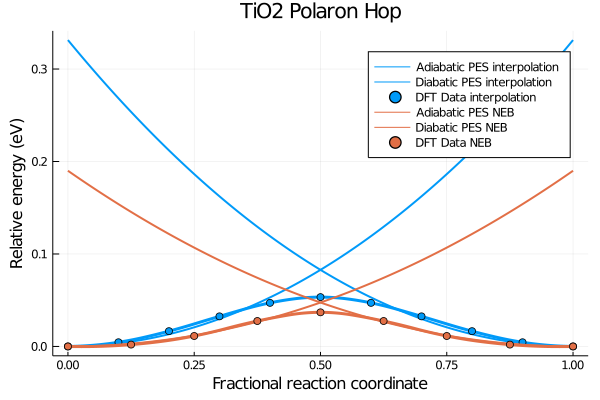

In [8]:
plt = plot(pot.Q,pot.E,lab = "Adiabatic PES interpolation",linewidth = 3,linecolor=1)
plt = plot!(pot_i.Q,pot_i.E,lab = "Diabatic PES interpolation",linewidth = 2,linecolor=1)
plt = plot!(pot_f.Q,pot_f.E,lab="",linewidth = 2,linecolor=1)
scatter!(pot.QE_data.Q,pot.QE_data.E, lab="DFT Data interpolation",
    markercolor=1,
    xlabel = "Fractional reaction coordinate",
    ylabel = "Relative energy (eV)",
    legend = true,
    title = "TiO2 Polaron Hop")
plt = plot!(pot_neb.Q,pot_neb.E,lab = "Adiabatic PES NEB",linewidth = 3,linecolor=2,thickness_scaling = 1)
plt = plot!(pot_i_neb.Q,pot_i_neb.E,lab = "Diabatic PES NEB",linewidth = 2,linecolor = 2)
plt = plot!(pot_f_neb.Q,pot_f_neb.E,lab="",linewidth = 2,linecolor = 2)
scatter!(pot_neb.QE_data.Q,pot_neb.QE_data.E, lab="DFT Data NEB",
    markercolor=2,
    xlabel = "Fractional reaction coordinate",
    ylabel = "Relative energy (eV)",
    legend = true,
    title = "TiO2 Polaron Hop")